In [166]:
import pandas as pd
import numpy as np

# Load dataset

In [2]:
df = pd.read_csv('../dataset/movies.csv')
df = df.dropna(subset=['genre'])
df.head()
df.shape

(3722, 20)

# Load embeddings

In [3]:
from pathlib import Path
import numpy as np

def read_embeddings(embedding_file: str):
    data = Path(embedding_file).read_text()
    lines = data.split('\n')
    filenames = []
    embeddings = []
    for line in lines:
        line_data = line.split(' ')
        if len(line_data) >= 2:
            filenames.append(line_data[0])
            embeddings.append(list(map(float, line_data[1:])))
    return np.asarray(filenames), np.asarray(embeddings)

In [12]:
mean_filenames, embeddings_mean = read_embeddings('../dataset/embeddings_mean.txt')
max_filenames, embeddings_max = read_embeddings('../dataset/embeddings_max.txt')
min_filenames, embeddings_min = read_embeddings('../dataset/embeddings_min.txt')

bert_mean_filenames, bert_mean = read_embeddings('../dataset/embeddings_bert_mean.txt')
bert_max_filenames, bert_max = read_embeddings('../dataset/embeddings_bert_max.txt')
bert_min_filenames, bert_min = read_embeddings('../dataset/embeddings_bert_min.txt')

bert_headtail_filenames, bert_headtail = read_embeddings('../dataset/embeddings_bert_headtail.txt')

In [13]:
bert_headtail[bert_headtail.shape == (0,)] = np.zeros((768,))

In [14]:
df = df[df['filename'].isin(mean_filenames)].copy()

In [16]:
mean_embeddings = []
max_embeddings = []
min_embeddings = []

mean_bert = []
max_bert = []
min_bert = []
ht_bert = []
for index, row in df.iterrows():
    mean_embeddings.append(embeddings_mean[np.where(mean_filenames == row.filename)].ravel())
    max_embeddings.append(embeddings_max[np.where(max_filenames == row.filename)].ravel())
    min_embeddings.append(embeddings_min[np.where(min_filenames == row.filename)].ravel())
    
    mean_bert.append((bert_mean[np.where(bert_mean_filenames == row.filename)].ravel()))
    max_bert.append((bert_max[np.where(bert_max_filenames == row.filename)].ravel()))
    min_bert.append((bert_min[np.where(bert_min_filenames == row.filename)].ravel()))
    
    ht_bert.append((bert_headtail[np.where(bert_headtail_filenames == row.filename)].ravel()))
    
df['fasttext_mean'] = mean_embeddings
df['fasttext_max'] = max_embeddings
df['fasttext_min'] = min_embeddings

df['bert_mean'] = mean_bert
df['bert_max'] = max_bert
df['bert_min'] = min_bert

df['bert_ht'] = ht_bert

mean_embeddings = np.asarray(mean_embeddings)
max_embeddings = np.asarray(max_embeddings)
min_embeddings = np.asarray(min_embeddings)

mean_bert = np.asarray(mean_bert)
max_bert = np.asarray(max_bert)
min_bert = np.asarray(min_bert)


ht_bert = np.asarray(ht_bert)



del embeddings_mean, embeddings_max, embeddings_min, bert_mean, bert_max, bert_min, bert_headtail

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

tfidf = TfidfVectorizer(max_features=1000, stop_words=get_stop_words('de'))

X_tfidf = tfidf.fit_transform(df.text)

# Compute clusters

In [220]:
N_CLUSTER = 25
FEATURES = X_tfidf.todense()

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from scipy.spatial.distance import cosine

clu = GaussianMixture(n_components=N_CLUSTER)
clu = KMeans(n_clusters=N_CLUSTER, n_jobs=-1)
clu = HDBSCAN(min_cluster_size=3, metric=cosine)
clu.fit(FEATURES)

labels = clu.fit_predict(FEATURES)
#probs = clu.predict_proba(FEATURES)

In [245]:
#np.round(clu.weights_, 2)

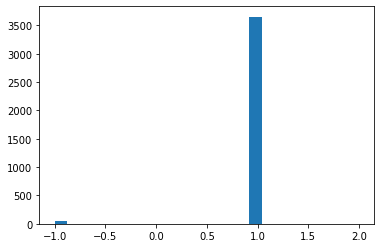

In [246]:
import matplotlib.pyplot as plt

plt.hist(labels, bins=N_CLUSTER)
plt.show()

# Inspect Clusters

In [169]:
import re
from collections import Counter
from stop_words import get_stop_words

mfw_per_cluster = []

stop_words = get_stop_words('de') + ['ja', 'nein', 'mal', 'hast']

for label in set(labels):
    curr_df = df[labels==label]
    text = " ".join(curr_df.text.str.lower())
    tokens = [t for t in re.findall(r'\w+', text) if t not in stop_words]
    freqs = Counter(tokens)
    print(f'Cluster {label}')
    print(f'{curr_df.shape[0]} Samples')
    print(*freqs.most_common(100), sep='\n')
    mfw_per_cluster.append(list(freqs.most_common(500)))
    print("\n\n")

Cluster 0
277 Samples
('schon', 6929)
('gut', 6551)
('s', 6302)
('komm', 4805)
('okay', 4749)
('oh', 4308)
('los', 4267)
('geht', 4054)
('bitte', 3991)
('hey', 3924)
('weiß', 3799)
('mann', 3748)
('mehr', 3179)
('na', 3066)
('willst', 2961)
('immer', 2923)
('danke', 2806)
('ganz', 2597)
('scheiße', 2546)
('wer', 2474)
('einfach', 2457)
('mach', 2449)
('weißt', 2425)
('warum', 2419)
('klar', 2413)
('lass', 2401)
('gehen', 2397)
('hallo', 2357)
('kannst', 2330)
('wirklich', 2217)
('gesagt', 2201)
('tut', 2189)
('sagen', 2176)
('kommt', 2150)
('vielleicht', 2118)
('sehen', 2039)
('gott', 2022)
('nie', 2001)
('hör', 1978)
('ok', 1928)
('gibt', 1883)
('tun', 1841)
('müssen', 1825)
('echt', 1794)
('leid', 1782)
('schön', 1761)
('ne', 1748)
('heute', 1730)
('sag', 1710)
('macht', 1698)
('ach', 1697)
('n', 1684)
('wieso', 1679)
('her', 1656)
('leben', 1572)
('gar', 1563)
('ab', 1552)
('geh', 1535)
('musst', 1515)
('zwei', 1514)
('raus', 1511)
('kommen', 1447)
('frau', 1444)
('genau', 1444)
('z

Cluster 6
142 Samples
('gut', 2858)
('schon', 2794)
('s', 2281)
('mehr', 1964)
('immer', 1940)
('weiß', 1931)
('geht', 1879)
('los', 1466)
('oh', 1444)
('nie', 1437)
('bitte', 1357)
('leben', 1333)
('danke', 1315)
('okay', 1283)
('mann', 1263)
('komm', 1254)
('sagen', 1236)
('sehen', 1210)
('warum', 1195)
('hey', 1165)
('ganz', 1163)
('wer', 1160)
('gibt', 1147)
('wurde', 1138)
('einfach', 1118)
('tun', 1109)
('gehen', 1106)
('wirklich', 1085)
('willst', 1058)
('vielleicht', 1020)
('zeit', 1009)
('heute', 978)
('leute', 953)
('wäre', 952)
('kommt', 932)
('müssen', 916)
('tut', 912)
('sagte', 906)
('hätte', 888)
('gesagt', 882)
('hallo', 881)
('zwei', 847)
('klar', 847)
('na', 846)
('ok', 844)
('gott', 841)
('weißt', 831)
('macht', 823)
('wissen', 806)
('liebe', 790)
('kommen', 780)
('mutter', 775)
('genau', 771)
('kannst', 767)
('zurück', 762)
('frau', 745)
('vater', 744)
('leid', 743)
('tag', 734)
('schön', 717)
('musik', 691)
('scheiße', 686)
('dachte', 673)
('viele', 672)
('ab', 671

Cluster 13
212 Samples
('gut', 4116)
('schon', 3770)
('bitte', 2578)
('komm', 2548)
('s', 2541)
('geht', 2403)
('los', 2378)
('mehr', 2322)
('weiß', 2144)
('immer', 2029)
('gehen', 1917)
('mann', 1834)
('wer', 1825)
('leben', 1782)
('warum', 1776)
('danke', 1702)
('vater', 1676)
('gott', 1595)
('sehen', 1544)
('kommt', 1512)
('willst', 1478)
('nie', 1475)
('gibt', 1459)
('frau', 1457)
('oh', 1416)
('lass', 1390)
('tun', 1337)
('ganz', 1324)
('sagen', 1322)
('müssen', 1311)
('mutter', 1308)
('kommen', 1289)
('na', 1261)
('kannst', 1230)
('gesagt', 1191)
('herr', 1187)
('zurück', 1184)
('heute', 1145)
('wirklich', 1143)
('zeit', 1133)
('tut', 1099)
('vielleicht', 1092)
('tag', 1068)
('hey', 1068)
('geh', 1058)
('macht', 1053)
('liebe', 1041)
('mach', 1032)
('hallo', 1026)
('weißt', 1022)
('her', 988)
('okay', 988)
('schön', 987)
('zwei', 978)
('sei', 971)
('wissen', 961)
('sohn', 950)
('sag', 938)
('einfach', 920)
('wurde', 915)
('wäre', 914)
('morgen', 891)
('sicher', 889)
('lassen', 87

Cluster 19
188 Samples
('s', 4710)
('gut', 4350)
('schon', 4213)
('los', 3059)
('geht', 2916)
('komm', 2743)
('oh', 2672)
('bitte', 2448)
('mehr', 2279)
('okay', 2257)
('hey', 2244)
('na', 2227)
('weiß', 2190)
('mann', 2173)
('immer', 2031)
('danke', 1897)
('ganz', 1810)
('wer', 1710)
('mach', 1661)
('willst', 1659)
('n', 1621)
('ne', 1586)
('klar', 1563)
('warum', 1563)
('kommt', 1559)
('gehen', 1495)
('gibt', 1465)
('einfach', 1455)
('hallo', 1429)
('sagen', 1425)
('müssen', 1424)
('lass', 1419)
('kannst', 1417)
('vielleicht', 1412)
('musik', 1386)
('scheiße', 1370)
('schön', 1332)
('sehen', 1320)
('wirklich', 1319)
('macht', 1318)
('heute', 1305)
('ab', 1300)
('tut', 1279)
('gesagt', 1273)
('nie', 1270)
('frau', 1263)
('weißt', 1235)
('ok', 1166)
('tun', 1159)
('zwei', 1143)
('gott', 1123)
('ach', 1122)
('kommen', 1102)
('gar', 1088)
('her', 1059)
('genau', 1047)
('sag', 1041)
('leben', 1039)
('leid', 1029)
('raus', 1022)
('hör', 1012)
('echt', 1007)
('zeit', 997)
('geh', 972)
('vat

In [170]:
mfw_per_cluster[3]

[('gut', 7232),
 ('schon', 5400),
 ('s', 5027),
 ('geht', 4219),
 ('danke', 3979),
 ('weiß', 3958),
 ('los', 3477),
 ('bitte', 3449),
 ('okay', 3377),
 ('mehr', 3094),
 ('warum', 3040),
 ('komm', 3011),
 ('hallo', 2840),
 ('immer', 2617),
 ('gehen', 2555),
 ('willst', 2449),
 ('tut', 2380),
 ('oh', 2327),
 ('sagen', 2283),
 ('hey', 2192),
 ('sehen', 2147),
 ('wirklich', 2120),
 ('nie', 2066),
 ('wer', 2043),
 ('mann', 2006),
 ('leid', 2005),
 ('vielleicht', 2003),
 ('einfach', 1990),
 ('na', 1912),
 ('gibt', 1911),
 ('tun', 1897),
 ('weißt', 1869),
 ('heute', 1852),
 ('ok', 1823),
 ('kannst', 1772),
 ('klar', 1770),
 ('ganz', 1763),
 ('gesagt', 1741),
 ('lass', 1698),
 ('kommt', 1678),
 ('schön', 1655),
 ('müssen', 1648),
 ('leben', 1595),
 ('zwei', 1594),
 ('frau', 1591),
 ('zeit', 1575),
 ('sicher', 1506),
 ('mach', 1505),
 ('tag', 1500),
 ('wissen', 1496),
 ('kommen', 1475),
 ('morgen', 1460),
 ('macht', 1449),
 ('wäre', 1418),
 ('liebe', 1413),
 ('gott', 1372),
 ('hör', 1346),
 ('z

In [238]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Xr_bht = pca.fit_transform(FEATURES)

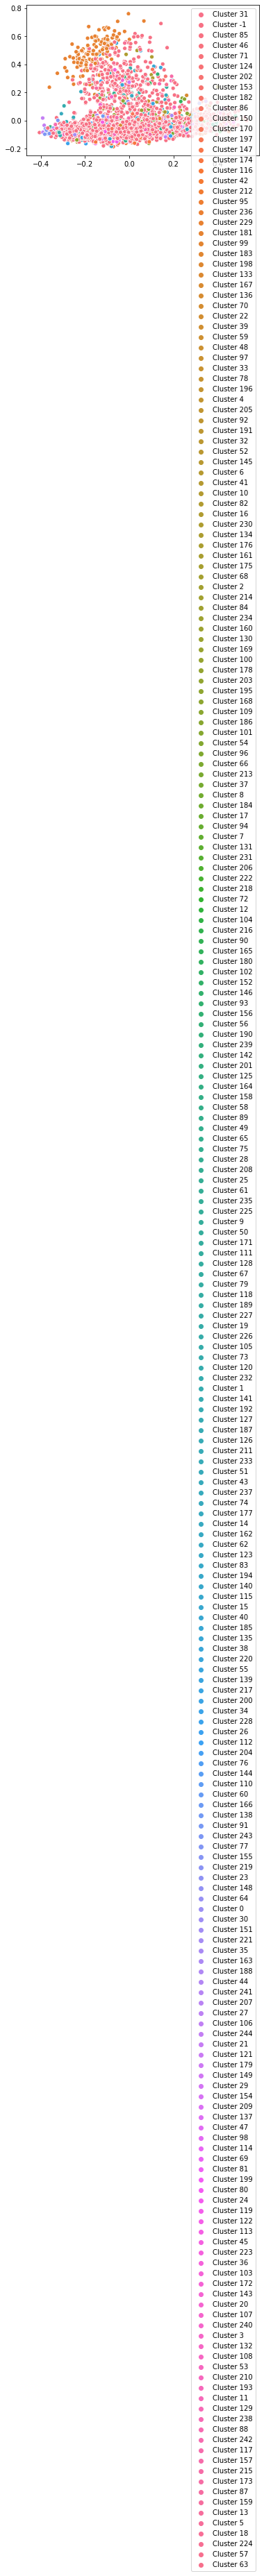

In [243]:
import seaborn as sns

sns.scatterplot(x=Xr_bht[:,0], y=Xr_bht[:,1], hue=[f'Cluster {l}' for l in labels])


# Plot year distribution of each cluster

<ipython-input-226-597462403e66>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


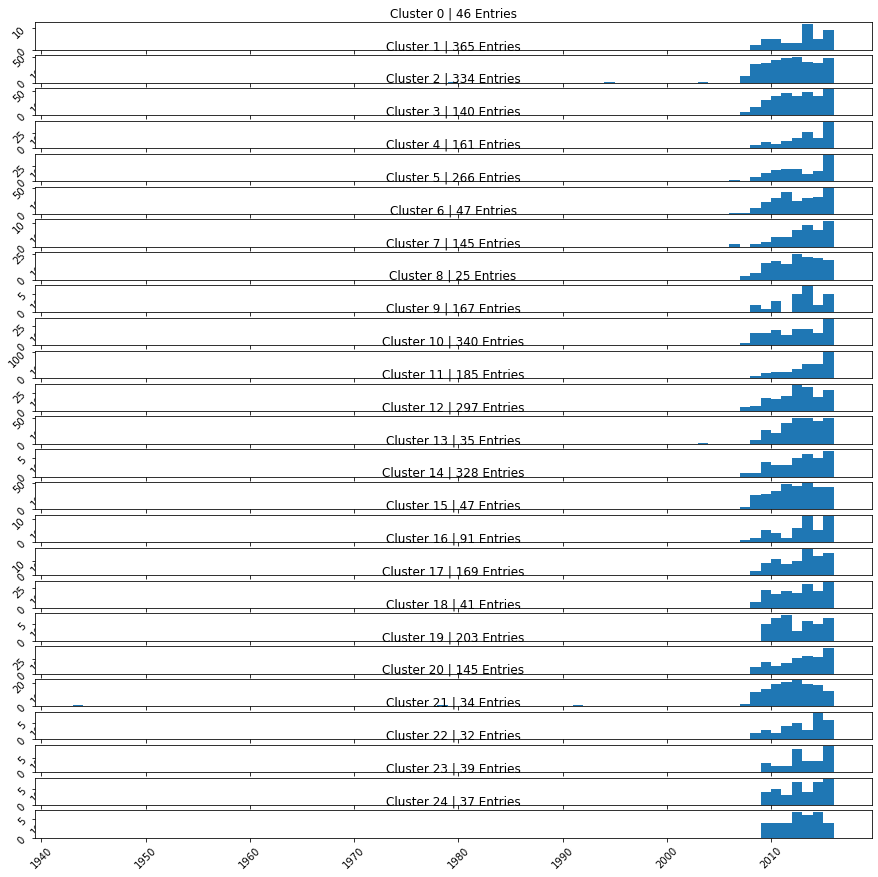

In [226]:
import matplotlib.pyplot as plt
from collections import Counter


fig, axs = plt.subplots(len(set(labels)), figsize=(15,15))
plt.xticks(rotation='vertical')


for index, label in enumerate(set(labels)):
    curr_df = df[labels==label]
    axs[index].hist(curr_df.year, bins=range(int(df.year.min()), int(df.year.max())))
    axs[index].tick_params(labelrotation=45)
    axs[index].set_title(f'Cluster {label} | {curr_df.shape[0]} Entries')

plt.tight_layout()
plt.show()

# Plot duration distribution of each cluster

<ipython-input-227-9bcd05a1c0db>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


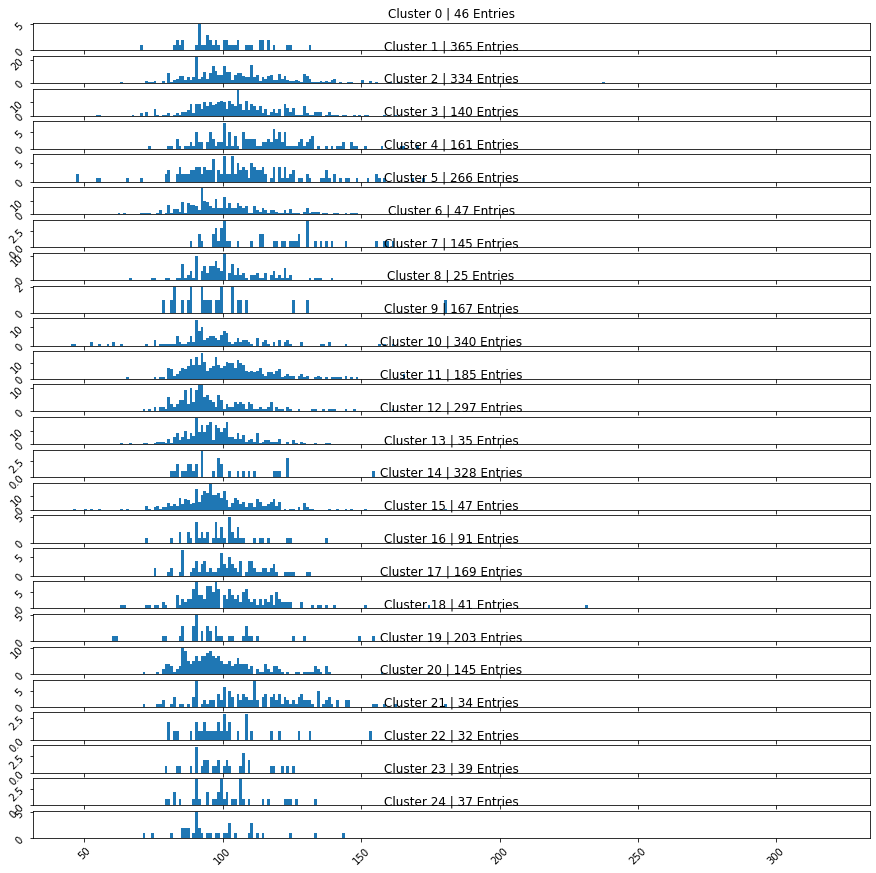

In [227]:
import matplotlib.pyplot as plt
from collections import Counter


fig, axs = plt.subplots(len(set(labels)), figsize=(15,15))
plt.xticks(rotation='vertical')


for index, label in enumerate(set(labels)):
    curr_df = df[labels==label]
    axs[index].hist(curr_df.runtimeMinutes, bins=range(int(df.runtimeMinutes.min()), int(df.runtimeMinutes.max())))
    axs[index].tick_params(labelrotation=45)
    axs[index].set_title(f'Cluster {label} | {curr_df.shape[0]} Entries')

plt.tight_layout()
plt.show()

# Plot year average imdb rating of each cluster

<ipython-input-228-b9113a0eb35d>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


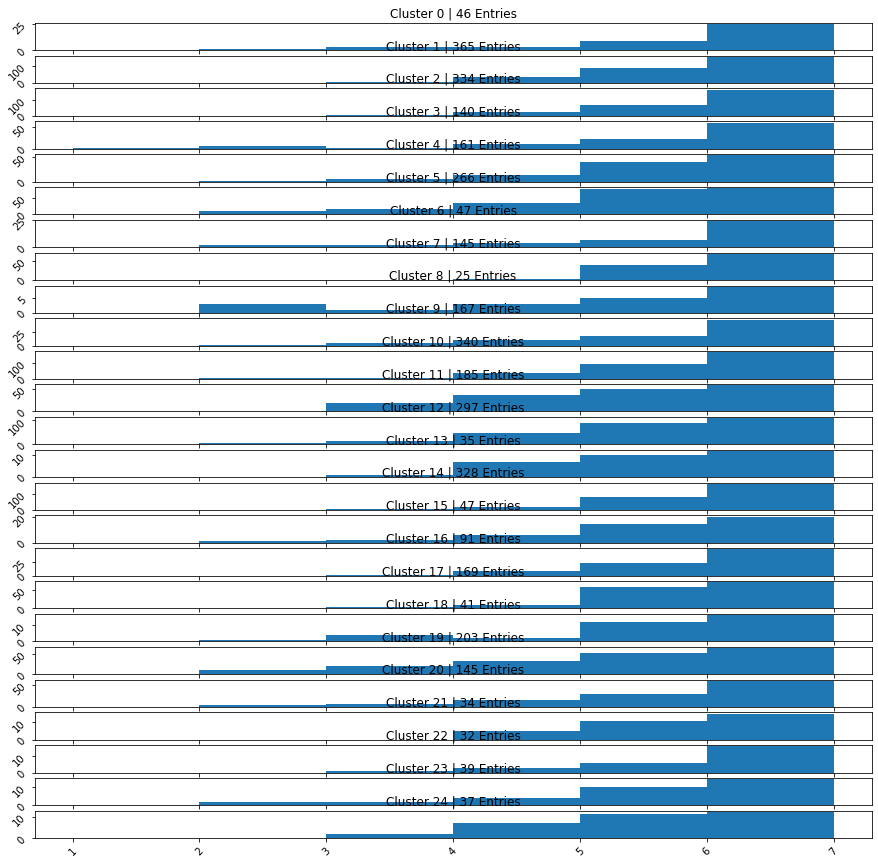

In [228]:
import matplotlib.pyplot as plt
from collections import Counter


fig, axs = plt.subplots(len(set(labels)), figsize=(15,15))
plt.xticks(rotation='vertical')


for index, label in enumerate(set(labels)):
    curr_df = df[labels==label]
    axs[index].hist(curr_df.averageRating, bins=range(int(df.averageRating.min()), int(df.averageRating.max())))
    axs[index].tick_params(labelrotation=45)
    axs[index].set_title(f'Cluster {label} | {curr_df.shape[0]} Entries')

plt.tight_layout()
plt.show()

# Plot production region (?!?!)

<ipython-input-229-67dd40e0aaf5>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


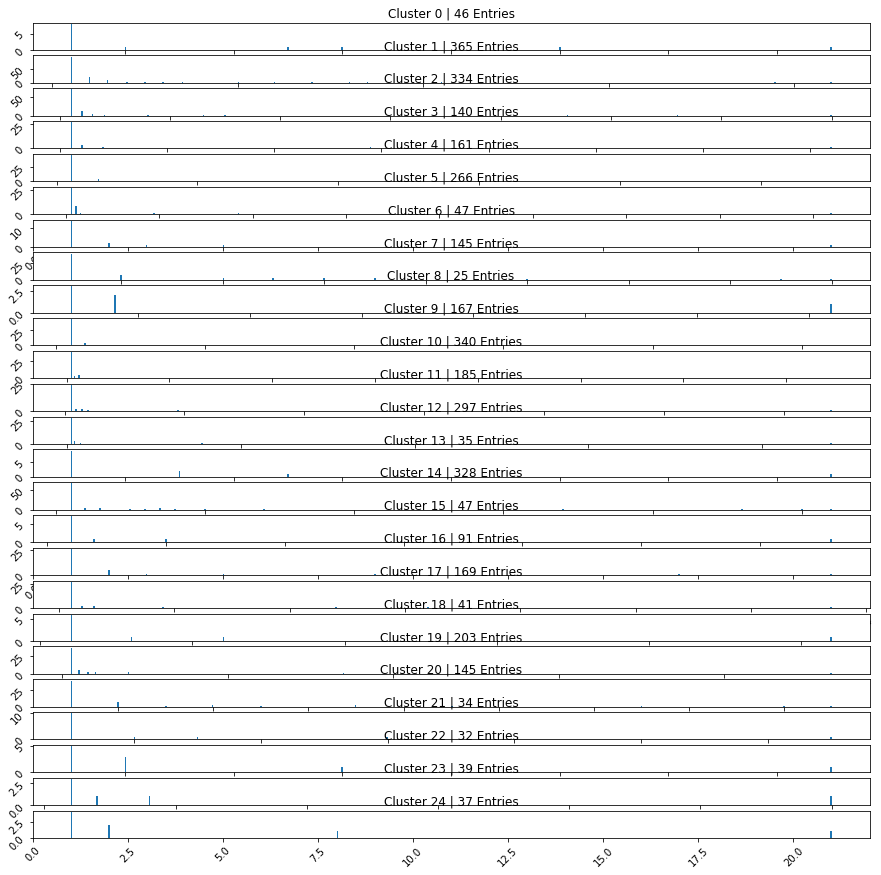

In [229]:
import matplotlib.pyplot as plt
from collections import Counter
from statistics import mean

fig, axs = plt.subplots(len(set(labels)), figsize=(15,15))
plt.xticks(rotation='vertical')


for index, label in enumerate(set(labels)):
    curr_df = df[labels==label]
    axs[index].hist(Counter(curr_df.production_region).values(), bins=(df.production_region.unique().shape[0]))
    axs[index].tick_params(labelrotation=45)
    axs[index].set_title(f'Cluster {label} | {curr_df.shape[0]} Entries')

plt.tight_layout()
plt.show()

In [231]:
df[labels==0].originalTitle.to_list()

['Un coeur simple',
 'Hunting Grounds',
 'Paul Blart: Mall Cop',
 'Julie & Julia',
 'Die Perlmutterfarbe',
 'Coeur animal',
 'The Seamstress',
 'Inhale',
 'Lemmy',
 'Vanishing on 7th Street',
 'Buried',
 "L'homme qui voulait vivre sa vie",
 'Paul',
 'The Ides of March',
 'Midnight in Paris',
 'Wrong',
 'Mann tut was Mann kann',
 'Au galop',
 'Broken City',
 'The Look of Love',
 'Schlussmacher',
 'Camille Claudel 1915',
 'A Stranger in Paradise',
 'Dead Man Down',
 'The Machine',
 'The Grand Seduction',
 'Sein letztes Rennen',
 "L'étrange couleur des larmes de ton corps",
 'Zum Geburtstag',
 'Win Win',
 'Revenge of the Green Dragons',
 'Avis de mistral',
 'Eden',
 'Saphirblau',
 'Quatsch und die Nasenbärbande',
 'Paul Blart: Mall Cop 2',
 'We Are Still Here',
 'Une famille à louer',
 'Le goût des merveilles',
 "L'étudiante et Monsieur Henri",
 'Allied',
 'Männertag',
 'Smaragdgrün',
 'Marie Curie',
 'The Black Room',
 'Picture of Beauty']

In [233]:
mfw_per_cluster[9]

[('schon', 1814),
 ('gut', 1571),
 ('mehr', 1539),
 ('vater', 1400),
 ('leben', 1351),
 ('mann', 1334),
 ('bitte', 1254),
 ('immer', 1233),
 ('wer', 1220),
 ('herr', 1178),
 ('weiß', 1161),
 ('los', 1140),
 ('warum', 1067),
 ('geht', 1067),
 ('gott', 1040),
 ('seid', 1004),
 ('gibt', 989),
 ('gehen', 961),
 ('kommt', 953),
 ('habt', 950),
 ('nie', 931),
 ('komm', 924),
 ('frau', 892),
 ('zeit', 872),
 ('müssen', 861),
 ('macht', 852),
 ('zurück', 844),
 ('bruder', 799),
 ('sehen', 791),
 ('tun', 788),
 ('mutter', 784),
 ('s', 782),
 ('könig', 766),
 ('liebe', 753),
 ('sagen', 741),
 ('oh', 735),
 ('ganz', 731),
 ('wurde', 726),
 ('wäre', 722),
 ('heute', 710),
 ('welt', 682),
 ('kommen', 675),
 ('vielleicht', 657),
 ('sohn', 650),
 ('wirklich', 634),
 ('willst', 611),
 ('lass', 598),
 ('kannst', 597),
 ('menschen', 595),
 ('tag', 592),
 ('lassen', 590),
 ('wissen', 587),
 ('sei', 574),
 ('danke', 552),
 ('na', 548),
 ('land', 545),
 ('wohl', 541),
 ('gesagt', 540),
 ('hätte', 533),
 ('

In [205]:
mean_cluster_prob_var = []
for l in np.unique(labels):
    probs_clu = probs[labels == l]
    mean_cluster_prob_var.append(probs_clu.var(axis=0).mean())

In [206]:
mean_cluster_prob_var

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [207]:
probs[labels == 0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])